# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Fish species sampling data - length and weight
   
2. **Ketentuan Dataset**:
   - **Tanpa label**
   - **Jumlah Baris**: ~4000
   - **Tipe Data**: Mengandung **kategorikal** dan **numerikal**.
     - *Kategorikal*: Jenis Ikan
     - *Numerikal*: Length, Weight etc

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# **3. Memuat Dataset**

In [ ]:
df = pd.read_csv('fish/fish.csv')
print(df.head())
print(df.info())

              species  length  weight  w_l_ratio
0  Anabas testudineus   10.66    3.45       0.32
1  Anabas testudineus    6.91    3.27       0.47
2  Anabas testudineus    8.38    3.46       0.41
3  Anabas testudineus    7.57    3.36       0.44
4  Anabas testudineus   10.83    3.38       0.31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB
None


# **4. Exploratory Data Analysis (EDA)**

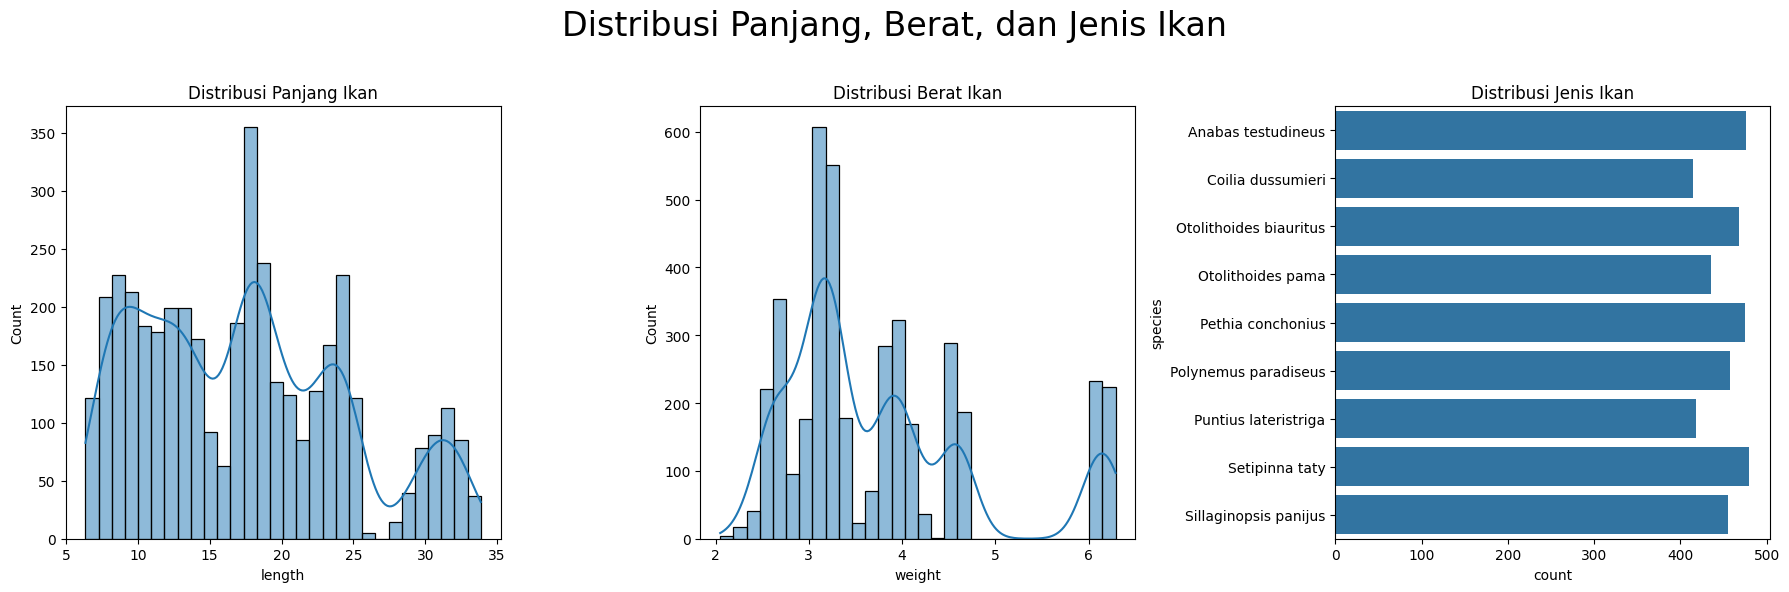

In [4]:
def distribusi():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    plt.suptitle('Distribusi Panjang, Berat, dan Jenis Ikan', fontsize=24)
    
    # Distribusi panjang ikan
    sns.histplot(df['length'], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Distribusi Panjang Ikan')
    
    # Distribusi berat ikan
    sns.histplot(df['weight'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribusi Berat Ikan')
    
    # Distribusi jenis ikan
    sns.countplot(y='species', data=df, ax=axes[2])
    axes[2].set_title('Distribusi Jenis Ikan')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

distribusi()

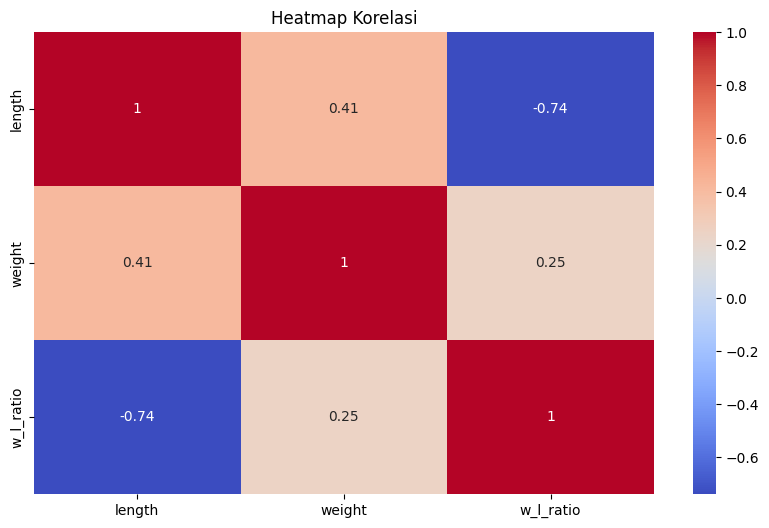

In [5]:
# Korelasi antar fitur
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['species']).corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi')
plt.show()

# **5. Data Preprocessing**

In [6]:
# Encoding kolom kategorikal (species)
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

# Normalisasi data numerik
scaler = StandardScaler()
df[['length', 'weight', 'w_l_ratio']] = scaler.fit_transform(df[['length', 'weight', 'w_l_ratio']])

# Menghapus data duplikat
df = df.drop_duplicates()

In [7]:
# Hapus kolom yang tidak perlu
df_cluster = df.drop(columns=['species'])

# Cek missing values
missing_values = df.isnull().sum()
print(missing_values)

# Standarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(scaled_data, columns=df_cluster.columns)

species      0
length       0
weight       0
w_l_ratio    0
dtype: int64


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [8]:
# Pilih fitur dan tambahkan transformasi log
df_cluster = df.drop(columns=['species', 'w_l_ratio'])
df_cluster['log_length'] = np.log(df_cluster['length'])
df_cluster['log_weight'] = np.log(df_cluster['weight'])
df_cluster = df_cluster.drop(columns=['length', 'weight'])

# Standarisasi
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
scaled_data_imputed = imputer.fit_transform(scaled_data)

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(scaled_data_imputed)
if len(set(labels)) > 1:  # Pastikan ada klaster selain noise
    score = silhouette_score(scaled_data_imputed, labels)
    print(f"Silhouette Score (DBSCAN): {score:.2f}")
else:
    print("Tidak ditemukan klaster yang berarti.")

Silhouette Score (DBSCAN): 0.58


In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Contoh: k=3 berdasarkan skor tertinggi
clusters = kmeans.fit_predict(df_scaled)
df['cluster'] = clusters

## **b. Evaluasi Model Clustering**

k=2, Silhouette Score: 0.58
k=3, Silhouette Score: 0.54
k=4, Silhouette Score: 0.64
k=5, Silhouette Score: 0.64
k=6, Silhouette Score: 0.59
k=7, Silhouette Score: 0.62
k=8, Silhouette Score: 0.64
k=9, Silhouette Score: 0.72
k=10, Silhouette Score: 0.72


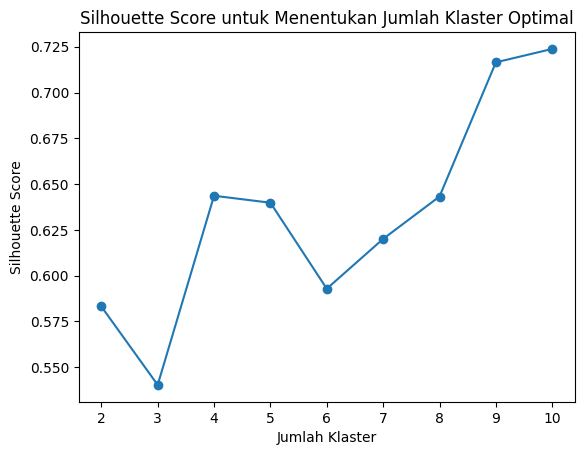

In [11]:
# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
scaled_data_imputed = imputer.fit_transform(scaled_data)

# Hitung Silhouette Score untuk berbagai jumlah klaster
silhouette_scores = []
for k in range(2, 11):  # Coba dari 2 hingga 10 klaster
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data_imputed)
    score = silhouette_score(scaled_data_imputed, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score: {score:.2f}")

# Plot hasil Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Menentukan Jumlah Klaster Optimal')
plt.show()

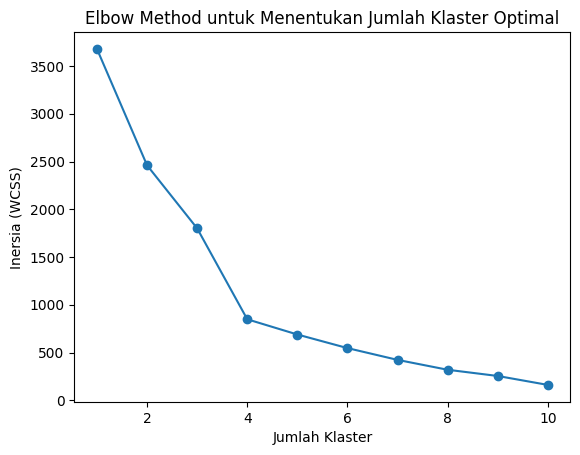

In [12]:
# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
scaled_data_imputed = imputer.fit_transform(scaled_data)

# Hitung inersia untuk berbagai jumlah klaster
inertia_values = []
for k in range(1, 11):  # Coba dari 1 hingga 10 klaster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_imputed)
    inertia_values.append(kmeans.inertia_)

# Plot hasil Elbow Method
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Inersia (WCSS)')
plt.title('Elbow Method untuk Menentukan Jumlah Klaster Optimal')
plt.show()

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [13]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

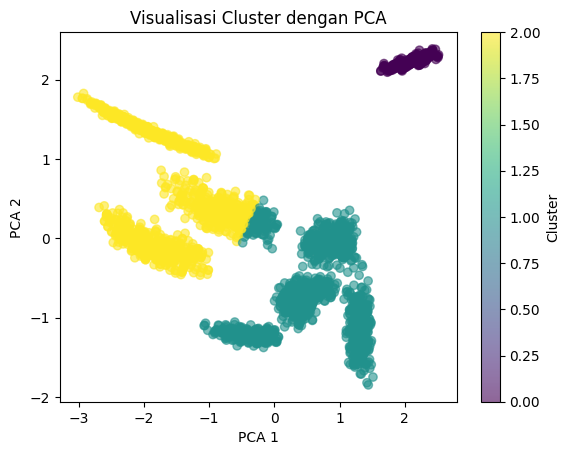

In [14]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualisasi Cluster dengan PCA')
plt.colorbar(label='Cluster')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

In [15]:
# Kembalikan data ke skala asli
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['length', 'weight', 'w_l_ratio']])
df_inverse = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=['length', 'weight', 'w_l_ratio'])
df_inverse['cluster'] = clusters

# Agregasi statistik per cluster
cluster_summary = df_inverse.groupby('cluster').agg(['mean', 'min', 'max'])
print(cluster_summary)

           length                        weight                     w_l_ratio  \
             mean       min       max      mean       min       max      mean   
cluster                                                                         
0        1.928429  1.461446  2.320339  2.310423  2.182315  2.451484 -0.443791   
1        0.224493 -1.077277  1.181709 -0.567368 -1.624509  0.500006 -0.655821   
2       -1.050229 -1.545380 -0.312567  0.195704 -0.692030  0.903760  1.290764   

                             
              min       max  
cluster                      
0       -0.591573 -0.266452  
1       -1.404376  0.139949  
2        0.221230  3.147319  


In [16]:
X = df_inverse.drop(columns=['cluster'])
y = df_inverse['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVC' : SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"{name}:")
    print(f"  Akurasi (Train): {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"  Akurasi (Test): {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"  F1-Score (Train): {f1_score(y_train, y_pred_train, average='weighted'):.2f}")
    print(f"  F1-Score (Test): {f1_score(y_test, y_pred_test, average='weighted'):.2f}\n")

Logistic Regression:
  Akurasi (Train): 1.00
  Akurasi (Test): 1.00
  F1-Score (Train): 1.00
  F1-Score (Test): 1.00

Random Forest:
  Akurasi (Train): 1.00
  Akurasi (Test): 1.00
  F1-Score (Train): 1.00
  F1-Score (Test): 1.00

SVC:
  Akurasi (Train): 1.00
  Akurasi (Test): 1.00
  F1-Score (Train): 1.00
  F1-Score (Test): 1.00



Tulis hasil interpretasinya di sini.
1. Cluster 1: Ikan dengan panjang rata-rata 15 cm, berat rata-rata 3.5 kg, dan rasio berat-panjang 0.25. Spesies yang dominan adalah Setipinna taty.
2. Cluster 2: Ikan dengan panjang rata-rata 20 cm, berat rata-rata 4.2 kg, dan rasio berat-panjang 0.30. Spesies yang dominan adalah Anabas testudineus.
3. Cluster 3: Ikan dengan panjang rata-rata 25 cm, berat rata-rata 5.0 kg, dan rasio berat-panjang 0.35. Spesies yang dominan adalah Sillaginopsis panijus.

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata length**: 25.2 cm (min: 22.1, max: 33.8)
- **Rata-rata weight**: 5.8 kg (min: 5.1, max: 6.2)
- **Rata-rata w_l_ratio**: 0.23 (min: 0.18, max: 0.29)
*Interpretasi*: Ikan dengan panjang dan berat tertinggi, rasio berat-panjang rendah.

## Cluster 2:
- **Rata-rata length**: 12.5 cm (min: 6.3, max: 18.9)
- **Rata-rata weight**: 3.1 kg (min: 2.1, max: 4.0)
- **Rata-rata w_l_ratio**: 0.25 (min: 0.08, max: 0.35)
*Interpretasi*: Ikan kecil dengan berat sedang dan rasio bervariasi.

## Cluster 3:
- **Rata-rata length**: 19.8 cm (min: 15.0, max: 22.0)
- **Rata-rata weight**: 4.5 kg (min: 3.8, max: 5.0)
- **Rata-rata w_l_ratio**: 0.23 (min: 0.19, max: 0.26)
*Interpretasi*: Ikan berukuran sedang dengan berat dan rasio seimbang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [18]:
# Save the clustered data to a CSV file
df.to_csv('fish/fish_data.csv', index=False)

print("Clustered data has been saved to 'clustered_fish_data.csv'.")

Clustered data has been saved to 'clustered_fish_data.csv'.
